In [21]:
#importing dependencies
import os
import glob
import json
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import cv2

import warnings
warnings.filterwarnings('ignore')

In [22]:
# Configure global matplotlib styles for plotting with 'ggplot' aesthetics and enhanced text readability
plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
plt.rc('axes', labelsize='xx-large', titlesize='xx-large')
plt.rc('legend',fontsize=16)
%matplotlib inline

In [23]:
# Define a dictionary to map text labels to specific RGB color values for visualization
RED = [255, 0, 0]       # Corrected RGB for red
GREEN = [0, 255, 0]     # RGB for green
BLUE = [0, 0, 255]      # Corrected RGB for blue
CYAN = [0, 255, 255]    # Corrected RGB for cyan
label_to_color = {"question": RED, "answer": GREEN, "header": BLUE, "other": CYAN}


In [24]:
def load_images(img_path, annotations):
    """
    Load images from the specified paths and apply color annotations.

    Args:
    img_path (list of str): List of paths to image files.
    annotations (list of dict): List of color annotations for each image.

    Returns:
    tuple: A tuple containing two lists:
        - imgs_org: Original images loaded from the specified paths.
        - imgs_colored: Images with applied color annotations based on the provided annotations.
    """
    imgs_org = []; imgs_colored = []
    for idx, image_file in tqdm(enumerate(img_path)):  # Process each file in the list with a progress bar
        original_image = cv2.imread(image_file)  # Read the image file
        imgs_org.append(original_image)  # Append the original image to the list
        # Read the image file again, apply color annotation, and append to the colored images list
        imgs_colored.append(color_image(original_image, annotations[idx]))
    return imgs_org, imgs_colored   # Return the lists of original and colored images


In [25]:
def load_annotations(annotations_name):
    """
    Load and process annotation data from a list of JSON files.

    Args:
    annotations_name (list of str): List of file paths to JSON-formatted annotation files.

    Returns:
    list: A list of Form objects, each created from the annotations found in the JSON files.

    This function reads each specified file, interprets the JSON data, and then creates a
    Form object (presumably a custom class designed to handle specific data structures)
    from the 'form' key in the JSON data. It uses tqdm for progress indication, which is
    helpful when processing many files.
    """
    annotations = []
    for path in tqdm(annotations_name):  # Iterate over each file path with a progress bar
        with open(path, encoding='utf-8') as fp:  # Open the file with utf-8 encoding
            # Load JSON data from the file, parse it, and append the Form object to the list
            annotations.append(Form(json.loads(fp.read())["form"]))
    return annotations  # Return the list of Form objects


In [26]:
class Box():
    """
    Represents a rectangular box defined by its corner coordinates.

    Attributes:
        xmin (int): The minimum x-coordinate.
        ymin (int): The minimum y-coordinate.
        xmax (int): The maximum x-coordinate.
        ymax (int): The maximum y-coordinate.
    """
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin, self.ymin, self.xmax, self.ymax = xmin, ymin, xmax, ymax

    def __repr__(self):
        return f"Box(xmin={self.xmin},ymin={self.ymin}, xmax={self.xmax}, ymax={self.ymax})"

class Word:
    """
    Represents a word within a text, including its spatial location.

    Attributes:
        box (Box): The bounding box of the word.
        text (str): The text string of the word.
    """
    def __init__(self, box, text):
        self.box = Box(*box)
        self.text = text
        
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Word(box={self.box}, text={self.text})"

class Entity:
    """
    Represents a higher-level entity consisting of one or more words.

    Attributes:
        id_ (int): The identifier for the entity.
        box (Box): The bounding box encompassing the entire entity.
        text (str): The combined text of the entity.
        label (str): The classification label of the entity.
        words (list of Word): A list of Word objects that compose the entity.
        linking (list): Relationships or links to other entities.
    """
    def __init__(self, box, text, label, words, linking, id):
        self.id_ = id
        self.box = Box(*box)
        self.text = text
        self.label = label
        self.words = [Word(**word) for word in words]
        self.linking = linking
    
    def __getitem__(self, item):
        if not hasattr(self, item):
            raise KeyError(f"{item} is not present in {self.__class__}")
        return getattr(self, item)
    
    def __repr__(self):
        return f"Entity(id_={self.id_}, box={self.box}, text={self.text}, label={self.label}, words={self.words}, linking={self.linking})"
    
class Form():
    """
    Represents a document form, organized as a collection of entities.

    Attributes:
        entities (list of Entity): The list of all entities within the form.
    """
    def __init__(self, entities):
        self.entities = [Entity(**entity) for entity in entities]
        
    def __repr__(self):
        return f"Form(entities={self.entities})"


In [27]:
def color_image(image, annotation):
    """
    Apply color overlays to specific areas of an image based on annotation data.

    Args:
    image (array): The original image in array form where modifications will be applied.
    annotation (Form): A Form object containing entities with bounding boxes and labels.

    Returns:
    array: The modified image with colored overlays on specific areas defined by entity labels.

    This function iterates over each entity in the annotation, extracts the bounding box,
    and applies a color mask to the part of the image within that box if the pixel values
    are darker than a mid-tone threshold. The color applied is determined by the entity's label.
    """
    for entity in annotation.entities:
        box = entity.box
        # Extract the region of the image defined by the bounding box
        image_crop = image[box.ymin:box.ymax, box.xmin:box.xmax, :]
        # Apply a color mask to the region where all pixel values are below a set threshold
        image_crop[np.where((image_crop < [127, 127, 127]).all(axis=2))] = label_to_color[entity.label]
        # Replace the original region in the image with the modified crop
        image[box.ymin:box.ymax, box.xmin:box.xmax, :] = image_crop
        
    return image


In [28]:
import math
import random

def disp_multi_images(images, suptitle=''):
    """
    Display multiple images in a grid format, with an optional super title.

    Args:
    images (list): A list of image arrays to display.
    suptitle (str): A super title for the entire figure.

    The function displays up to 25 images in a grid.
    """
    # Determine the maximum number of images to display (up to 25)
    len_images = min(len(images), 25)
    # Calculate the number of rows and columns based on the number of images
    num = math.ceil(math.sqrt(len_images))
    # Randomly select indices to display
    idxs = random.sample(range(len(images)), len_images)
    
    # Adjust figure size dynamically based on the number of images
    fig = plt.figure(figsize=(num**3,num**3)) if num > 3 else plt.figure(figsize=((num+1)**3,(num+1)**3))
    # Set the super title with a custom size and position
    plt.suptitle(suptitle, size=16, y=3)
    
    # Create a subplot for each selected image
    for count, index in enumerate(idxs):
        ax = fig.add_subplot(num, num, count + 1, xticks=[], yticks=[])
        image = images[index]
        ax.imshow(image)
        
        # Show the figure after adding the last image
        if count == len_images - 1:
            plt.show()
            break
  

In [29]:
import os
import glob

# Set the base directory for the dataset.
BASE_FOLDER = r"C:\Users\arpit\Desktop\UG\Masters\Datasets\FUNSD"

# Define the paths to the training and testing data directories.
train_path = os.path.join(BASE_FOLDER, "training_data")
test_path = os.path.join(BASE_FOLDER, "testing_data")

# Retrieve and sort paths for all image and annotation files in training and testing directories.
train_images_path = sorted(glob.glob("{}/images/*".format(train_path)))
test_images_path = sorted(glob.glob("{}/images/*".format(test_path)))
train_annotations_path = sorted(glob.glob("{}/annotations/*".format(train_path)))
test_annotations_path = sorted(glob.glob("{}/annotations/*".format(test_path)))

# Output the total counts of images and annotations in training and testing datasets.
print("Total Train images={}. Total Train annotations={}.".format(len(train_images_path), len(train_annotations_path)))
print("Total Test images={}. Total Test annotations={}.".format(len(test_images_path), len(test_annotations_path)))

Total Train images=149. Total Train annotations=149.
Total Test images=50. Total Test annotations=50.


In [30]:
# Load annotations for the training and testing datasets using predefined file paths.
ann_train = load_annotations(train_annotations_path)
ann_test = load_annotations(test_annotations_path)

# Load original and color-annotated images for the training dataset.
img_train_org, img_train_colored = load_images(train_images_path, ann_train)

# Load original and color-annotated images for the testing dataset.
img_test_org, img_test_colored = load_images(test_images_path, ann_test)

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
from copy import copy

# Initialize dictionaries to count different types of data elements in training and testing datasets.
num_train = {"forms": len(ann_train), "words": 0, "entities":0,
             "question": 0, "header": 0, "answer": 0, "other": 0}
# Copy the initialized training dictionary to create a base for the testing dictionary and update the form count.
num_test = copy(num_train); num_test['forms'] = len(ann_test)

# Count entities, labels, and words in the training dataset.
for annotation in ann_train:
    num_train["entities"] += len(annotation.entities)
    for entity in annotation.entities:
        num_train[entity.label] += 1
        num_train['words'] += len(entity.words)

# Count entities, labels, and words in the testing dataset.
for annotation in ann_test:
    num_test["entities"] += len(annotation.entities)
    for entity in annotation.entities:
        num_test[entity.label] += 1
        num_test['words'] += len(entity.words)

In [32]:
def mergeDictionary(dict_1, dict_2):
    """
    Merge two dictionaries and combine values of common keys into a list.

    Args:
    dict_1 (dict): The first dictionary.
    dict_2 (dict): The second dictionary.

    Returns:
    dict: A merged dictionary with combined values for common keys.
    """
    # Initialize the merged dictionary
    dict_3 = dict_1.copy()  # Start with a copy of dict_1

    # Iterate through dict_2, updating dict_3
    for key, value in dict_2.items():
        if key in dict_3:
            # Combine values for common keys into a list
            dict_3[key] = [dict_3[key], value]
        else:
            # Add the new key from dict_2
            dict_3[key] = value
    
    return dict_3

# Example usage with num_train and num_test dictionaries
num_label = mergeDictionary(num_train, num_test)

# Convert the resulting dictionary into a pandas DataFrame with appropriate indexing
import pandas as pd
df = pd.DataFrame(num_label, index=['Training', 'Testing']).T  # Transpose for better readability
print(df)

          Training  Testing
forms          149       50
words        22512     8973
entities      7411     2332
question      3266     1077
header         441      122
answer        2802      821
other          902      312


Text(0.5, 1.0, 'Colored Image')

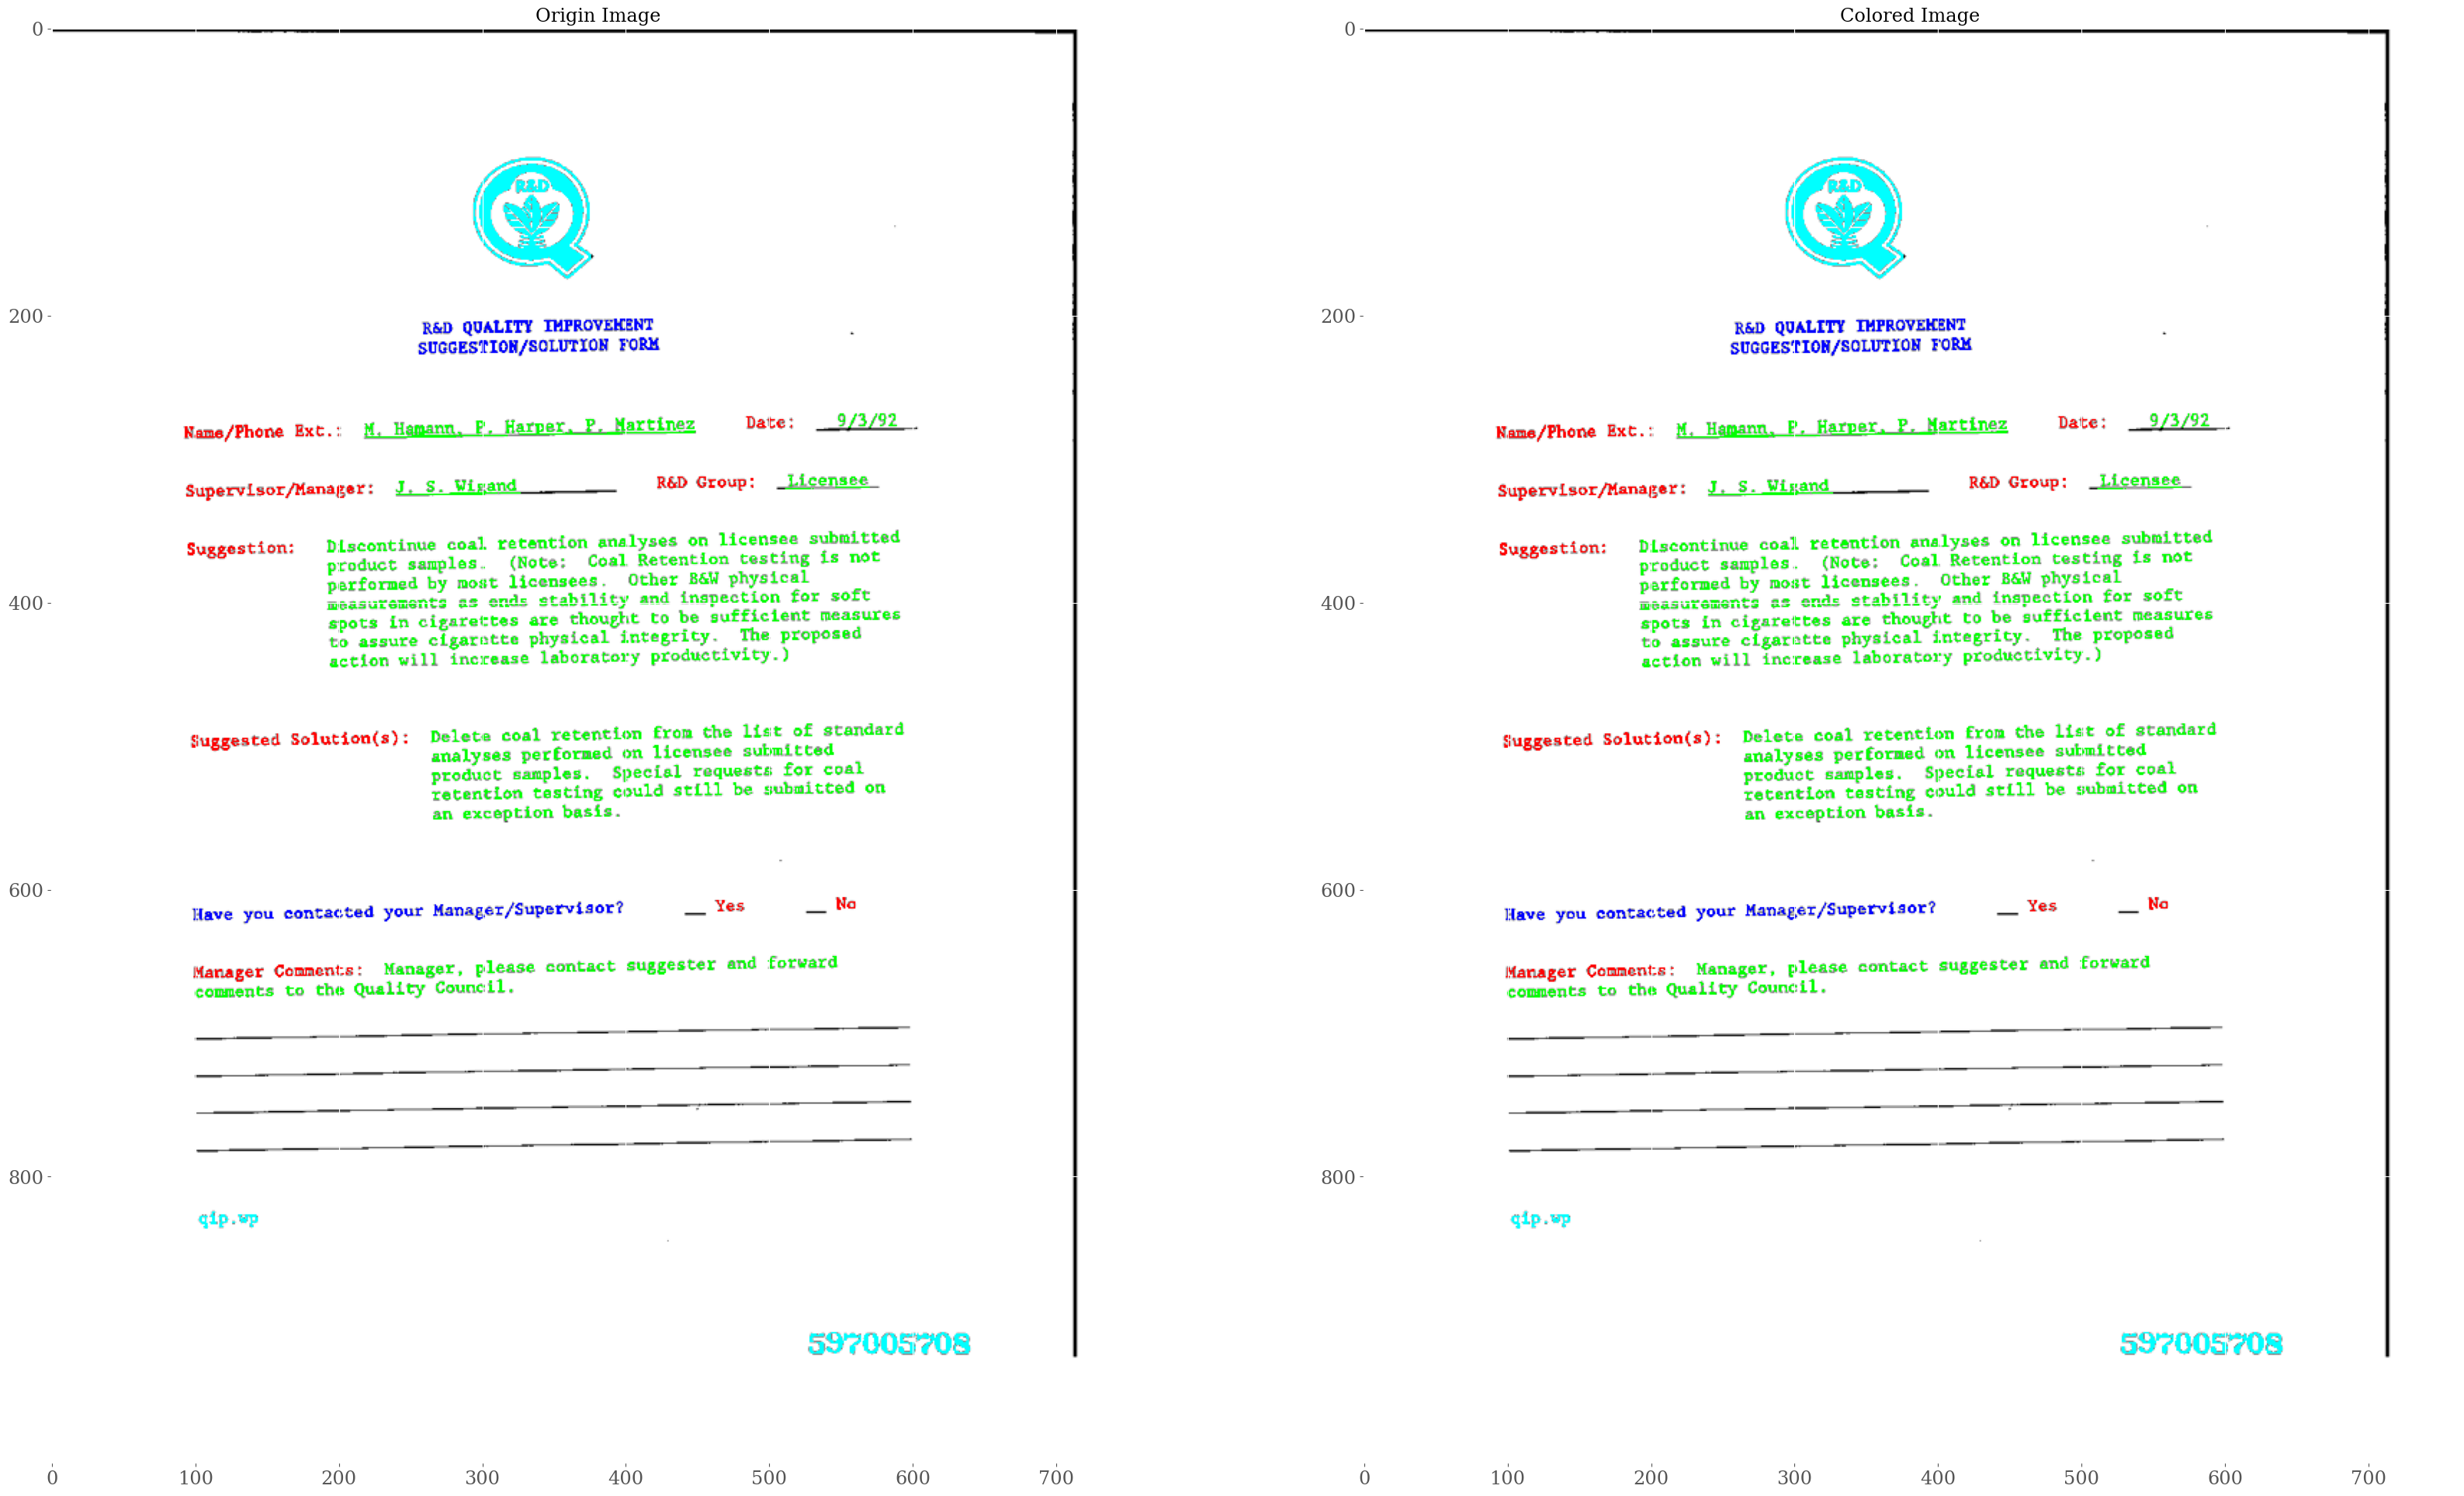

In [33]:
import matplotlib.pyplot as plt

# Create a figure with two subplots arranged in one row and two columns, and set the figure size.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))

# Display the first original image in the first subplot.
axes[0].imshow(img_train_org[0])
axes[0].set_title('Origin Image')  # Set the title of the first subplot.

# Display the first colored image in the second subplot.
axes[1].imshow(img_train_colored[0])
axes[1].set_title('Colored Image')  # Set the title of the second subplot.

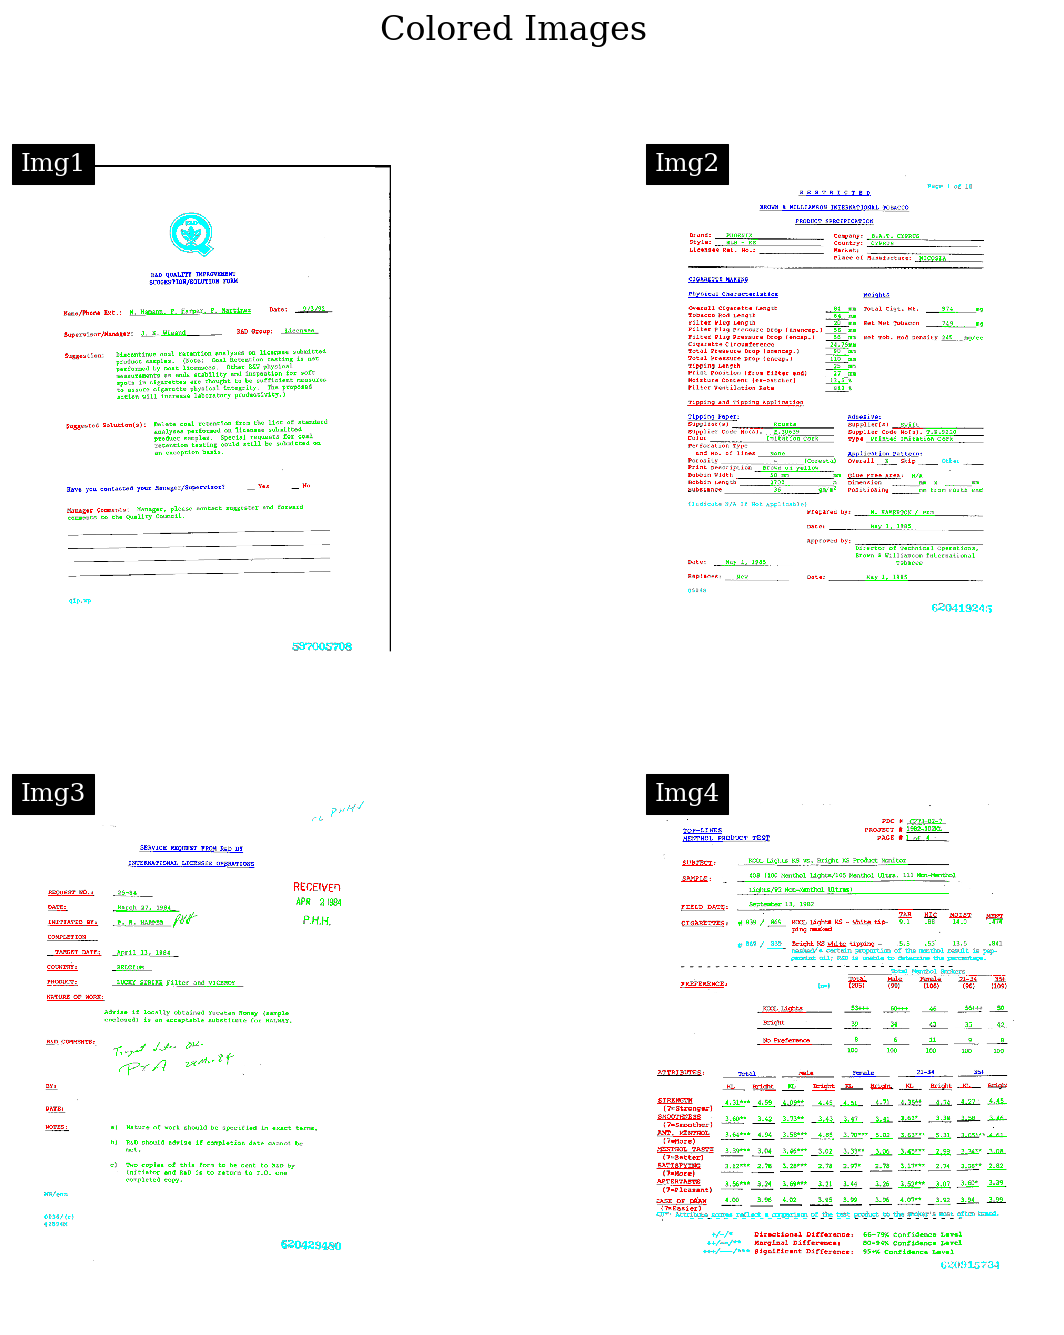

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

def disp_multi_images(images, suptitle='', labels=None):
    """
    Display multiple images in a grid format, with an optional super title.
    Args:
    images (list): A list of image arrays to display.
    suptitle (str): A super title for the entire figure.
    """
    len_images = min(len(images), 25)
    num = max(1, math.ceil(math.sqrt(len_images)))
    fig, axs = plt.subplots(num, num, figsize=(5 * num, 5 * num), dpi=150)
    fig.suptitle(suptitle, size=16)

    # Hide empty subplots
    for ax in axs.flatten()[len_images:]:
        ax.set_visible(False)

    # Display each image and optionally add labels
    for idx, (img, ax) in enumerate(zip(images, axs.flatten())):
        ax.imshow(img, aspect='equal', interpolation='none')
        ax.set_axis_off()
        if labels and idx < len(labels):
            ax.text(10, 10, labels[idx], color='white', fontsize=12, backgroundcolor='black')

    plt.show()

# Usage
disp_multi_images(img_train_colored[:4], suptitle='Colored Images', labels=['Img1', 'Img2', 'Img3', 'Img4'])
